In [135]:
from glob import glob
from src.systems.humanoid.system import HumanoidSystem
from src.flow_matching.humanoid.latent_conditional.flow_matcher import HumanoidLatentConditionalFlowMatcher
from matplotlib import pyplot as plt

import numpy as np
import os
import torch

data_dir = "/common/users/shared/pracsys/genMoPlan/data_trajectories/humanoid_get_up_medium"
roa_file = "/common/users/shared/pracsys/genMoPlan/data_trajectories/humanoid_get_up_slow/roa_labels.txt"
bounds_file = "/common/users/dm1487/arcmg_datasets/humanoid_get_up/humanoid_data_bounds.pkl"
system = HumanoidSystem(bounds_file=bounds_file, use_dynamic_bounds=True, head_height_threshold=1.4, torso_z_threshold=0.9, speed_threshold=0.2)

ckpt_path = "/common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/humanoid_slow/2025-11-02_14-22-07"
flow_matcher = HumanoidLatentConditionalFlowMatcher.load_from_checkpoint(ckpt_path, device="cuda:0")


✅ Loaded Humanoid bounds from: /common/users/dm1487/arcmg_datasets/humanoid_get_up/humanoid_data_bounds.pkl
📊 Per-Dimension Normalization Limits:

   Euclidean Block 1 (dims 0-33):
     [ 0]: ±  0.859
     [ 1]: ±  1.375
     [ 2]: ±  0.725
     [ 3]: ±  0.526
     [ 4]: ±  0.633
     ... (29 more dimensions)

   Sphere (dims 34-36): NO NORMALIZATION (unit norm)

   Euclidean Block 2 (dims 37-66):
     [37]: ±  1.914
     [38]: ±  1.916
     [39]: ±  3.328
     [40]: ±  2.790
     [41]: ±  2.940
     ... (25 more dimensions)

Loaded Humanoid bounds from: /common/users/dm1487/arcmg_datasets/humanoid_get_up/humanoid_data_bounds.pkl
📁 Folder provided: /common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs/humanoid_slow/2025-11-02_14-22-07
🔍 Searching for checkpoint in folder...
   ✓ Found best checkpoint (val_loss=0.0273)
   📄 Using: epoch207-val_loss0.0273.ckpt
🤖 Loading Humanoid LCFM checkpoint: /common/home/dm1487/robotics_research/tripods/olympics-classifier/outputs

In [136]:
roa_data = np.loadtxt(roa_file, delimiter=",")
inp, labels = roa_data[:, :67], roa_data[:, 67]
inp = torch.from_numpy(inp).float().to("cuda:0")
labels = torch.from_numpy(labels).long().to("cuda:0")
np.mean(roa_data[:, 67] == 0)


0.6168666666666667

In [141]:
idx = 3
samples = 100
repeats = 1
print("Success", (labels[idx] == 1).item())
all_head_heights = []

for _ in range(samples):
    model_input = inp[idx:idx+1, :].clone()
    head_height = []
    for i in range(repeats):
        pred = flow_matcher.predict_endpoint(model_input)
        head_height.append(pred[:, 21].item())
        model_input = pred.clone()
    all_head_heights.append(head_height)
    
print(all_head_heights)
sum(np.array(all_head_heights) > 1.4 if labels[idx] == 1 else np.array(head_height) < 1.4)

Success True
[[0.08934973925352097], [0.1914149522781372], [0.22226080298423767], [0.07723059505224228], [1.4506860971450806], [1.4489421844482422], [0.20764341950416565], [1.4448059797286987], [0.10500655323266983], [1.4474788904190063], [0.21400703489780426], [1.448255181312561], [0.08603006601333618], [1.4489375352859497], [1.4497473239898682], [0.09480658918619156], [1.4497253894805908], [1.4497417211532593], [1.4485024213790894], [0.09475769102573395], [1.451134204864502], [1.4496201276779175], [0.22691825032234192], [1.4483942985534668], [1.4497005939483643], [0.09263036400079727], [0.19910278916358948], [1.433254599571228], [0.09690356254577637], [0.11238208413124084], [0.09810556471347809], [1.4446748495101929], [0.09554360806941986], [1.4496495723724365], [0.19321204721927643], [0.08979374915361404], [1.4482148885726929], [1.448155403137207], [0.0948324203491211], [1.4494099617004395], [1.4415253400802612], [0.09372658282518387], [0.22550728917121887], [0.19365663826465607], [

array([42])

In [120]:
all_head_heights

[[0.09335245192050934],
 [1.4527033567428589],
 [0.20986990630626678],
 [1.4584167003631592],
 [0.09703171253204346],
 [1.4531811475753784],
 [1.455980896949768],
 [1.4571298360824585],
 [0.19984076917171478],
 [0.08910045027732849],
 [1.4546808004379272],
 [0.08391902595758438],
 [1.4467318058013916],
 [1.4555351734161377],
 [1.4564684629440308],
 [0.0930333137512207],
 [0.09563959389925003],
 [0.09241341799497604],
 [1.4539403915405273],
 [0.17818382382392883]]

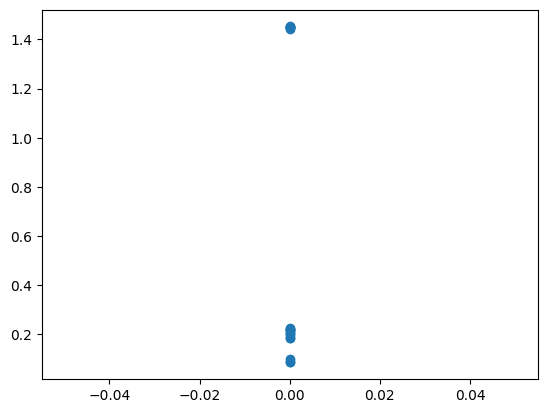

In [39]:
# 1d plot of head height
plt.plot([0]*samples, head_height, "o")
plt.show()


In [32]:
success_count = 0
failure_count = 0
success_lengths = []
failure_lengths = []
from tqdm import tqdm

for file in tqdm(glob(os.path.join(data_dir, "trajectories/*.txt"))):
    data = np.loadtxt(file, delimiter=",")
    success = False
    for i in range(data.shape[0]):
        if system.is_in_attractor(data[i:i+1]).item():
            success_count += 1
            success_lengths.append(i+1)
            success = True
            break
    if not success:
        failure_count += 1
        failure_lengths.append(data.shape[0])
        
    if (success_count + failure_count) % 1000 == 0:
        print(f"Success count: {success_count}")
        print(f"Failure count: {failure_count}")
        print(f"Success rate: {success_count / (success_count + failure_count)}")
        print(f"Failure rate: {failure_count / (success_count + failure_count)}")
        print(f"Success lengths: {np.median(success_lengths)}")
        print(f"Failure lengths: {np.median(failure_lengths)}")

  7%|▋         | 1011/15000 [00:13<03:03, 76.16it/s]

Success count: 876
Failure count: 124
Success rate: 0.876
Failure rate: 0.124
Success lengths: 114.0
Failure lengths: 361.0


 13%|█▎        | 2015/15000 [00:26<02:39, 81.18it/s]

Success count: 1763
Failure count: 237
Success rate: 0.8815
Failure rate: 0.1185
Success lengths: 113.0
Failure lengths: 367.0


 20%|██        | 3007/15000 [00:39<02:47, 71.64it/s]

Success count: 2624
Failure count: 376
Success rate: 0.8746666666666667
Failure rate: 0.12533333333333332
Success lengths: 113.0
Failure lengths: 367.0


 27%|██▋       | 4008/15000 [00:52<02:27, 74.40it/s]

Success count: 3478
Failure count: 522
Success rate: 0.8695
Failure rate: 0.1305
Success lengths: 113.0
Failure lengths: 367.0


 33%|███▎      | 5009/15000 [01:06<02:11, 76.13it/s]

Success count: 4359
Failure count: 641
Success rate: 0.8718
Failure rate: 0.1282
Success lengths: 113.0
Failure lengths: 367.0


 40%|████      | 6008/15000 [01:19<01:56, 76.88it/s]

Success count: 5215
Failure count: 785
Success rate: 0.8691666666666666
Failure rate: 0.13083333333333333
Success lengths: 113.0
Failure lengths: 367.0


 47%|████▋     | 7008/15000 [01:32<01:41, 78.70it/s]

Success count: 6089
Failure count: 911
Success rate: 0.8698571428571429
Failure rate: 0.13014285714285714
Success lengths: 112.0
Failure lengths: 367.0


 53%|█████▎    | 8007/15000 [01:45<01:34, 74.27it/s]

Success count: 6966
Failure count: 1034
Success rate: 0.87075
Failure rate: 0.12925
Success lengths: 113.0
Failure lengths: 367.0


 60%|██████    | 9006/15000 [01:58<01:18, 76.35it/s]

Success count: 7831
Failure count: 1169
Success rate: 0.8701111111111111
Failure rate: 0.1298888888888889
Success lengths: 113.0
Failure lengths: 367.0


 67%|██████▋   | 10014/15000 [02:12<01:05, 76.40it/s]

Success count: 8718
Failure count: 1282
Success rate: 0.8718
Failure rate: 0.1282
Success lengths: 113.0
Failure lengths: 367.0


 73%|███████▎  | 11009/15000 [02:25<00:56, 70.60it/s]

Success count: 9571
Failure count: 1429
Success rate: 0.8700909090909091
Failure rate: 0.12990909090909092
Success lengths: 113.0
Failure lengths: 367.0


 80%|████████  | 12011/15000 [02:38<00:38, 78.01it/s]

Success count: 10428
Failure count: 1572
Success rate: 0.869
Failure rate: 0.131
Success lengths: 113.0
Failure lengths: 367.0


 87%|████████▋ | 13010/15000 [02:52<00:25, 77.03it/s]

Success count: 11280
Failure count: 1720
Success rate: 0.8676923076923077
Failure rate: 0.13230769230769232
Success lengths: 113.0
Failure lengths: 367.0


 93%|█████████▎| 14013/15000 [03:05<00:13, 74.14it/s]

Success count: 12131
Failure count: 1869
Success rate: 0.8665
Failure rate: 0.1335
Success lengths: 113.0
Failure lengths: 367.0


100%|██████████| 15000/15000 [03:18<00:00, 75.40it/s]

Success count: 12987
Failure count: 2013
Success rate: 0.8658
Failure rate: 0.1342
Success lengths: 113.0
Failure lengths: 367.0


In [29]:

print(f"Success count: {success_count}")
print(f"Failure count: {failure_count}")
print(f"Success rate: {success_count / (success_count + failure_count)}")
print(f"Failure rate: {failure_count / (success_count + failure_count)}")

Success count: 6896
Failure count: 8104
Success rate: 0.4597333333333333
Failure rate: 0.5402666666666667


In [30]:
print(f"Success lengths: {np.median(success_lengths)}")
print(f"Failure lengths: {np.median(failure_lengths)}")

Success lengths: 192.0
Failure lengths: 441.0
